In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv("./application_record.csv", encoding = 'utf-8')
record = pd.read_csv("./credit_record.csv", encoding = 'utf-8')

In [3]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(data)
# profile

In [4]:
# profile = ProfileReport(record)
# profile

IDENTIFY NULL VALUES AND DELEATING THE COLUMN

In [5]:
df_null = data.isna().sum()
df_null_values = df_null[df_null>0]
df_null_values.sort_values(ascending=False)

OCCUPATION_TYPE    134203
dtype: int64

In [6]:
data.drop(["OCCUPATION_TYPE"],axis =1,inplace=True)

In [7]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,2.0


In [8]:
#examining the duplicate IDs, sorting by ID
duplicated_ids = record[record['ID'].duplicated(keep='first')]['ID'].values
record[record['ID'].isin(duplicated_ids)].sort_values(by=['ID',"MONTHS_BALANCE"]).head(10)

,ID,MONTHS_BALANCE,STATUS
3,5001711,-3,0
2,5001711,-2,0
1,5001711,-1,0
0,5001711,0,X
22,5001712,-18,0
21,5001712,-17,0
20,5001712,-16,0
19,5001712,-15,0
18,5001712,-14,0
17,5001712,-13,0


In [9]:
print("unique ID's: ",len(data["ID"].unique()))
print("total number rows: ", data.shape[0])
print("Difference: ", data.shape[0]- len(data["ID"].unique()))
print("Number of duplicated rows: ",sum(data.duplicated()))

unique ID's:  438510
total number rows:  438557
Difference:  47
Number of duplicated rows:  0


In [10]:
print("Number of duplicated rows: ",sum(record.duplicated()))

Number of duplicated rows:  0


In [11]:
record.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [12]:
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month 
# X: No loan for the month

status_ratio_df = pd.DataFrame(record.groupby(['ID', 'STATUS'])['STATUS'].count())\
                                .rename(columns={'STATUS': 'STATUS_count'})\
                                .reset_index()
status_ratio_df


,ID,STATUS,STATUS_count
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [13]:
conditions = [
    status_ratio_df['STATUS']=='0',
    status_ratio_df['STATUS']=='1',
    status_ratio_df['STATUS']=='2', 
    status_ratio_df['STATUS']=='3',
    status_ratio_df['STATUS']=='4', 
    status_ratio_df['STATUS']=='5',
    status_ratio_df['STATUS']=='X', 
    status_ratio_df['STATUS']=='C'
    ]

choices = [0,1,1,1,1,1,0,0]

status_ratio_df['bad_client'] = np.select(conditions, choices, default=0)
clients_rate = status_ratio_df.groupby(['ID'])\
    .sum('bad_client')\
    .reset_index()\
    .drop(['STATUS_count'], axis=1)

clients_rate


,ID,bad_client
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [14]:
print(len(clients_rate[(clients_rate["bad_client"]== 1)]))
print(len(clients_rate[(clients_rate["bad_client"]== 0)]))

4792
40635


In [15]:
# Mapping the client id with the applicants table
consolidate = data.copy()

consolidate['BAD_CLIENT'] = consolidate['ID']\
    .map(clients_rate.set_index('ID')['bad_client'])

consolidate.dropna(subset=['BAD_CLIENT'], inplace=True)
consolidate.shape

(36457, 18)

In [16]:
consolidate

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,BAD_CLIENT
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,0.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,2.0,2.0
434809,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,2.0,5.0
434810,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,2.0,5.0
434811,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,2.0


In [17]:
consolidate["TARGET"] = np.where(consolidate["BAD_CLIENT"] == 0, 0, 1)
consolidate

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,BAD_CLIENT,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,0.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,2.0,2.0,1
434809,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,2.0,5.0,1
434810,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,2.0,5.0,1
434811,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,2.0,1


In [18]:
categorical_features = consolidate.select_dtypes(include = ["object"]).columns
numerical_features = consolidate.select_dtypes(exclude = ["object"]).columns
# numerical_features = numerical_features.drop("")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = consolidate[numerical_features]
df_cat = consolidate[categorical_features]

Numerical features : 12
Categorical features : 7


In [19]:
# removal of outlier:
from IPython.display import display
df1 = consolidate
df3 = consolidate

features1 = numerical_features

for i in features1:
    Q1 = df1[i].quantile(0.05)
    Q3 = df1[i].quantile(0.95)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
consolidate = df1

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,BAD_CLIENT,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,0.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0,0



Inference:
Before removal of outliers, The dataset had 36457 samples.
After removal of outliers, The dataset now has 36135 samples.


In [20]:
corr = df_num.corr()
corr.sort_values(["TARGET"], ascending= False, inplace=True)
print(corr.TARGET)

TARGET              1.000000
BAD_CLIENT          0.832101
DAYS_BIRTH          0.028943
AMT_INCOME_TOTAL    0.024202
FLAG_EMAIL          0.019658
CNT_CHILDREN        0.011525
CNT_FAM_MEMBERS     0.009004
ID                  0.003565
FLAG_WORK_PHONE    -0.000149
FLAG_PHONE         -0.006355
DAYS_EMPLOYED      -0.021566
FLAG_MOBIL               NaN
Name: TARGET, dtype: float64


In [21]:
consolidate.drop(["BAD_CLIENT","FLAG_MOBIL",  "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL", "ID", "CNT_FAM_MEMBERS" ],axis =1,inplace=True)
consolidate


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36130,M,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1
36131,F,Y,Y,0,130500.0,Working,Secondary / secondary special,Married,House / apartment,-16137,-9391,1
36132,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1
36133,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1


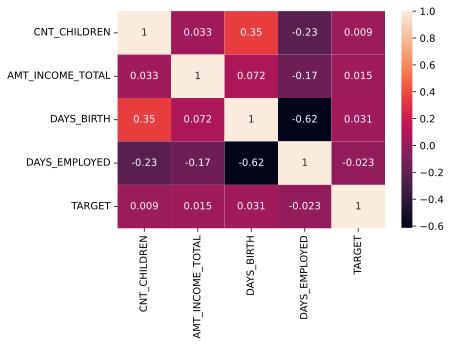

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = consolidate.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [23]:

df = pd.get_dummies(consolidate, ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'])
df

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,TARGET,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,427500.0,-12005,-4542,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,427500.0,-12005,-4542,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,112500.0,-21474,-1134,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,0,270000.0,-19110,-3051,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,270000.0,-19110,-3051,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36130,0,90000.0,-19101,-1721,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
36131,0,130500.0,-16137,-9391,1,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
36132,0,315000.0,-17348,-2420,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
36133,0,283500.0,-17958,-655,1,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0


In [24]:
corr = df.corr()
corr.sort_values(["TARGET"], ascending= False, inplace=True)
print(corr.TARGET)

TARGET                                               1.000000
DAYS_BIRTH                                           0.030739
FLAG_OWN_REALTY_N                                    0.025012
CODE_GENDER_M                                        0.017669
NAME_EDUCATION_TYPE_Incomplete higher                0.016064
AMT_INCOME_TOTAL                                     0.015226
NAME_INCOME_TYPE_State servant                       0.013485
NAME_INCOME_TYPE_Commercial associate                0.012972
FLAG_OWN_CAR_N                                       0.012844
NAME_FAMILY_STATUS_Single / not married              0.011012
NAME_FAMILY_STATUS_Civil marriage                    0.010438
NAME_EDUCATION_TYPE_Academic degree                  0.010134
NAME_HOUSING_TYPE_With parents                       0.009211
CNT_CHILDREN                                         0.008990
NAME_HOUSING_TYPE_Rented apartment                   0.008041
NAME_HOUSING_TYPE_Office apartment                   0.005953
NAME_HOU

In [25]:
# Dataset balancing

Bad = df[df.TARGET == 1]
Good = df[df.TARGET == 0]

print(len(Bad))
print(len(Good))

4032
32103


In [26]:
good_indexes = Good.index

np.random.seed(42)
random_good_indexes = np.random.choice(good_indexes, len(Bad))

Good = df.loc[random_good_indexes]

bln = Bad.append(Good)

print(len(bln[bln.TARGET == 1]))
print(len(bln[bln.TARGET == 0]))

4032
4032


In [27]:
# dependent and independent variables 
X = bln.drop(columns=["TARGET"])
y = bln["TARGET"]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score

In [30]:
classifiers = {
    "Naivebayes": GaussianNB(),
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

In [31]:
train_scores = []
test_scores = []
test_recall_scores = []
test_precision_scores = []
acc_scores = []

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    train_scores.append(train_score)
    test_score = classifier.score(X_test, y_test)
    test_scores.append(test_score)
    y_pred = classifier.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    acc_scores.append(acc_score)
    test_recall_score = recall_score(y_test, y_pred)
    test_recall_scores.append(test_recall_score)
    test_precision_score = precision_score(y_test, y_pred)
    test_precision_scores.append(test_precision_score)


print("train_scores: " + str(train_scores))
print("test_recall_scores: " + str(test_recall_scores))
print("test_precision_scores: " + str(test_precision_scores))
print("acc_scores: " + str(acc_scores))

[19:38:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train_scores: [0.5155917788802268, 0.5228561304039688, 0.7388377037562013, 0.528880226789511, 0.9289510985116939, 0.9289510985116939, 0.8703047484053863]
test_recall_scores: [0.5465787304204451, 0.4542456718878813, 0.6108821104699094, 0.42126957955482275, 0.6356141797197032, 0.6644682605111294, 0.6529266281945589]
test_precision_scores: [0.5291300877893057, 0.5242626070409134, 0.5793588741204065, 0.5334029227557411, 0.6675324675324675, 0.6813186813186813, 0.6454767726161369]
acc_scores: [0.5289256198347108, 0.5198347107438016, 0.5826446280991735, 0.525206611570248, 0.6586776859504132, 0.6760330578512397, 0.6462809917355372]


In [32]:
from sklearn.model_selection import GridSearchCV

#randomforest model
params = [{'n_estimators': [100, 250, 500], 'criterion': ['gini','entropy'], 'max_features': ["auto", "sqrt", "log2"]}]

rfc = GridSearchCV(RandomForestClassifier(random_state=42), params,cv=3)
rfc.fit(X_train, y_train)

print(rfc.score)    

<bound method BaseSearchCV.score of GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [100, 250, 500]}])>


In [33]:
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(rfc.best_params_)

0.6714876033057852
{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 500}


In [36]:
#DecisionTreeClassifier model
params = [{'splitter': ["best", "random"], 'criterion': ['gini','entropy']}]

dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), params,cv=3)
dtc.fit(X_train, y_train)

print(dtc.score)    


<bound method BaseSearchCV.score of GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])>


In [ ]:
y_pred = dtc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(dtc.best_params_)

0.665702479338843
{'criterion': 'gini', 'splitter': 'random'}


In [37]:
#XGBClassifier model
params = [{'loss': ["deviance", "exponential"], 'learning_rate': [0.1, 0.2, 0.05], 'n_estimators': [100, 250, 500], 'criterion': ["friedman_mse", "squared_error", "mse"]}]

xgbc = GridSearchCV(XGBClassifier(random_state=42), params,cv=3)
xgbc.fit(X_train, y_train)

print(xgbc.score)    


y_pred = xgbc.predict(X_test)
print(accuracy_score(y_test, y_pred))

[19:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "criterion", "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mis

In [ ]:
y_pred = xgbc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.653305785123967


In [ ]:
print(xgbc.best_params_)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'n_estimators': 500}
